In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

import joblib
import warnings
warnings.filterwarnings("ignore")

# For XGBoost
from xgboost import XGBClassifier

RANDOM_STATE = 42
sns.set_style('whitegrid')   # Seaborn whitegrid
sns.set_palette('deep')



In [3]:
DATA_PATH = "E:/InsuranceClaim/Insurance.csv"  # adjust if needed
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (1338, 8)


,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [4]:
print("----- INFO -----")
print(df.info())
print("\n----- DESCRIPTION -----")
print(df.describe(include='all').T)

print("\n----- MISSING VALUES -----")
print(df.isnull().sum())

----- INFO -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   sex             1338 non-null   int64  
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   int64  
 5   region          1338 non-null   int64  
 6   charges         1338 non-null   float64
 7   insuranceclaim  1338 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 83.8 KB
None

----- DESCRIPTION -----
                 count          mean           std        min         25%  \
age             1338.0     39.207025     14.049960    18.0000    27.00000   
sex             1338.0      0.505232      0.500160     0.0000     0.00000   
bmi             1338.0     30.663397      6.098187    15.9600    26.29625   
children        1338.0      1.094918  

In [5]:
for col in ['sex', 'smoker', 'region', 'insuranceclaim', 'children']:
    if col in df.columns:
        print(f"{col} unique:", df[col].unique())

sex unique: [0 1]
smoker unique: [1 0]
region unique: [3 2 1 0]
insuranceclaim unique: [1 0]
children unique: [0 1 3 2 5 4]



Target value counts:
insuranceclaim
1    783
0    555
Name: count, dtype: int64 

insuranceclaim
1    0.585202
0    0.414798
Name: proportion, dtype: float64


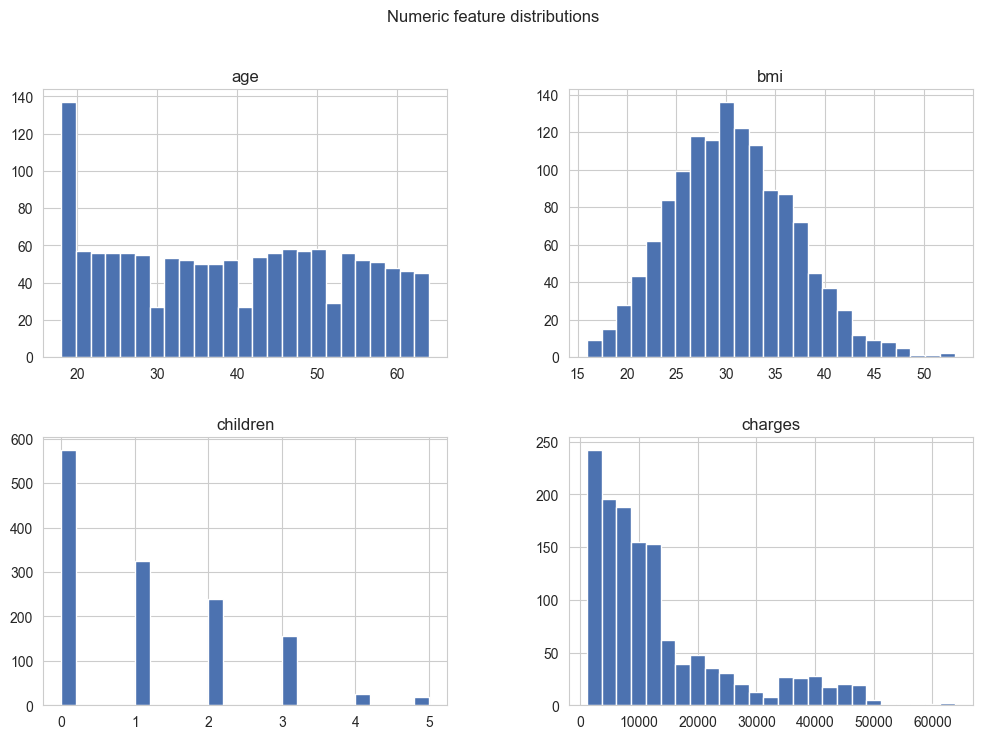

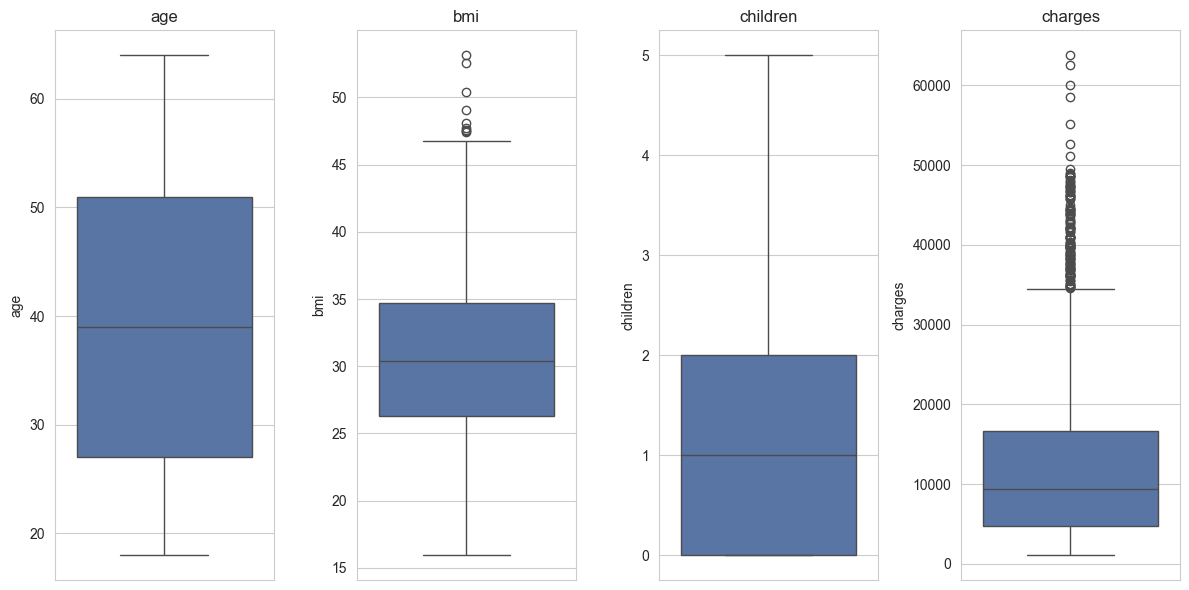

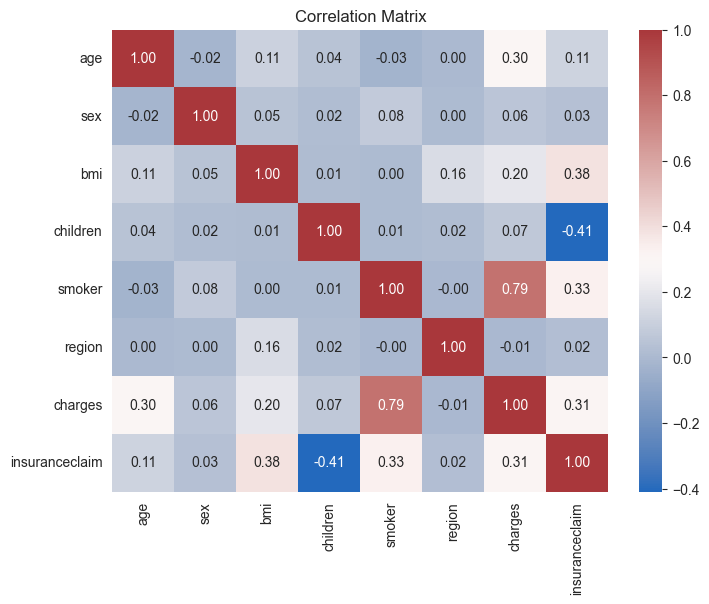

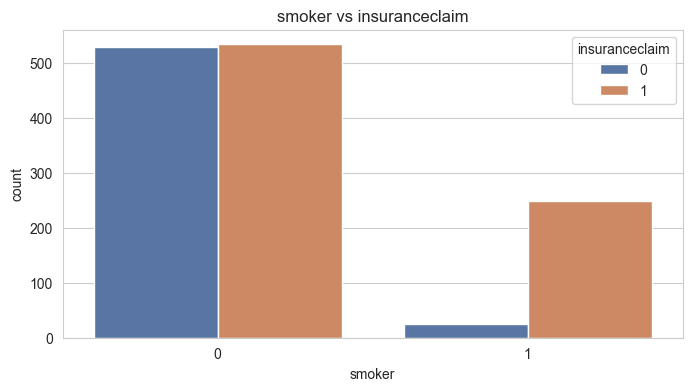

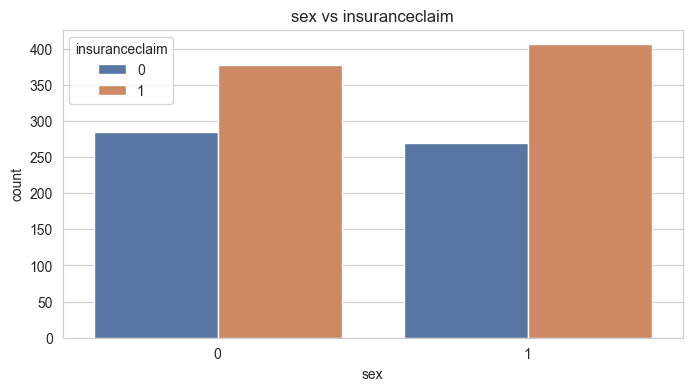

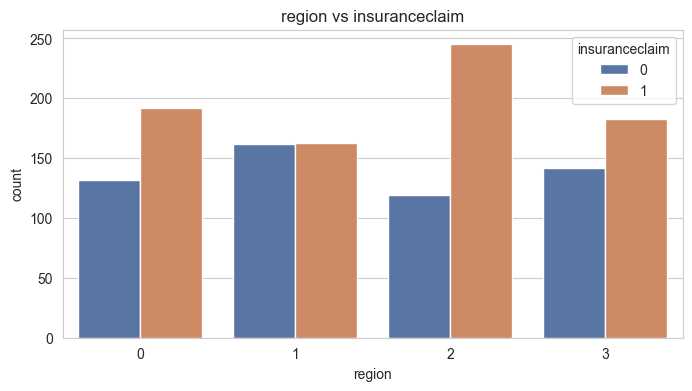


Mean charges by insuranceclaim:
insuranceclaim
0     8821.421892
1    16423.928277
Name: charges, dtype: float64


In [8]:
target = 'insuranceclaim'
print("\nTarget value counts:")
print(df[target].value_counts(), "\n")
print(df[target].value_counts(normalize=True))


num_cols = ['age', 'bmi', 'children', 'charges']  # fixed
df[num_cols].hist(figsize=(12,8), bins=25)
plt.suptitle("Numeric feature distributions")
plt.show()


plt.figure(figsize=(12,6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation Matrix")
plt.show()


categorical_cols = ['smoker', 'sex', 'region']
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue=target, data=df)
    plt.title(f"{col} vs {target}")
    plt.show()


print("\nMean charges by insuranceclaim:")
print(df.groupby(target)['charges'].mean())

In [29]:
features_all = ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
features_no_charges = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']



df['bmi_category'] = pd.cut(df['bmi'], bins=[0,18.5,25,30,100], labels=['underweight','normal','overweight','obese'])
df['age_bucket'] = pd.cut(df['age'], bins=[0,25,40,60,120], labels=['young','adult','midage','senior'])


print("\nCross-tab bmi_category vs insuranceclaim:")
print(pd.crosstab(df['bmi_category'], df[target], normalize='index'))


Cross-tab bmi_category vs insuranceclaim:
insuranceclaim         0         1
bmi_category                      
underweight     0.619048  0.380952
normal          0.823009  0.176991
overweight      0.448187  0.551813
obese           0.259574  0.740426


In [30]:
numeric_cols = ['age', 'bmi', 'children', 'charges'] 
categorical_cols = ['sex', 'smoker', 'region']
derived_cat_cols = ['bmi_category', 'age_bucket']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols + derived_cat_cols)
], remainder='drop')


In [31]:
df[derived_cat_cols] = df[derived_cat_cols].astype(object)

df = df.dropna(subset=[target]).reset_index(drop=True)

X_with = df[features_all + derived_cat_cols]
X_no_charges = df[features_no_charges + derived_cat_cols]
y = df[target].astype(int)

print("X_with shape:", X_with.shape)
print("X_no_charges shape:", X_no_charges.shape)
print("y shape:", y.shape)

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    X_with, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
Xn_train, Xn_test, yn_train, yn_test = train_test_split(
    X_no_charges, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train/test sizes (with charges):", Xw_train.shape, Xw_test.shape)
print("Train/test sizes (no charges):", Xn_train.shape, Xn_test.shape)


X_with shape: (1338, 9)
X_no_charges shape: (1338, 8)
y shape: (1338,)
Train/test sizes (with charges): (1070, 9) (268, 9)
Train/test sizes (no charges): (1070, 8) (268, 8)


In [32]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        try:
            y_proba = model.decision_function(X_test)
        except:
            y_proba = None

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    if roc is not None:
        print(f"ROC-AUC: {roc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return {'model': model_name, 'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec, 'roc_auc': roc}

def plot_roc(models_info, X_test, y_test, title="ROC Curves"):
    plt.figure(figsize=(8,6))
    for name, model in models_info.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:,1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
        else:
            # try decision_function
            if hasattr(model, "decision_function"):
                y_score = model.decision_function(X_test)
                fpr, tpr, _ = roc_curve(y_test, y_score)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

In [38]:
def train_and_evaluate(X_train, X_test, y_train, y_test, include_charges=True, do_grid=True):
    """
    Trains Logistic Regression, Decision Tree, Random Forest, XGBoost.
    Returns trained models dict and evaluation results list.
    """
    
    numeric_cols_local = ['age', 'bmi', 'children']
    if include_charges:
        numeric_cols_local = ['age', 'bmi', 'children', 'charges']

    categorical_cols_local = ['sex','smoker','region']
    derived_local = ['bmi_category','age_bucket']

    local_preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), 
                          ('scaler', StandardScaler())]), numeric_cols_local),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), 
                          ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), 
                categorical_cols_local + derived_local)
    ], remainder='drop')

    results = []
    trained_models = {}

    # Logistic Regression
    pipe_lr = Pipeline(steps=[
        ('pre', local_preprocessor),
        ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ])
    if do_grid:
        param_grid = {'clf__C': [0.01, 0.1, 1, 10]}
        gs = GridSearchCV(pipe_lr, param_grid, cv=5, scoring='f1', n_jobs=-1)
        gs.fit(X_train, y_train)
        best_lr = gs.best_estimator_
        print("Logistic best params:", gs.best_params_)
    else:
        best_lr = pipe_lr.fit(X_train, y_train)

    trained_models['LogisticRegression'] = best_lr
    results.append(evaluate_model(best_lr, X_test, y_test, "Logistic Regression"))

    # Decision Tree
    pipe_dt = Pipeline(steps=[('pre', local_preprocessor), 
                              ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])
    if do_grid:
        param_grid = {'clf__max_depth': [3,5,7,10, None], 'clf__min_samples_split':[2,5,10]}
        gs = GridSearchCV(pipe_dt, param_grid, cv=5, scoring='f1', n_jobs=-1)
        gs.fit(X_train, y_train)
        best_dt = gs.best_estimator_
        print("DecisionTree best params:", gs.best_params_)
    else:
        best_dt = pipe_dt.fit(X_train, y_train)

    trained_models['DecisionTree'] = best_dt
    results.append(evaluate_model(best_dt, X_test, y_test, "Decision Tree"))

    # Random Forest
    pipe_rf = Pipeline(steps=[('pre', local_preprocessor), 
                              ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])
    if do_grid:
        param_grid = {'clf__n_estimators': [100,200], 'clf__max_depth': [5,10, None], 'clf__min_samples_split':[2,5]}
        gs = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
        gs.fit(X_train, y_train)
        best_rf = gs.best_estimator_
        print("RandomForest best params:", gs.best_params_)
    else:
        best_rf = pipe_rf.fit(X_train, y_train)

    trained_models['RandomForest'] = best_rf
    results.append(evaluate_model(best_rf, X_test, y_test, "Random Forest"))

    # XGBoost
    pipe_xgb = Pipeline(steps=[('pre', local_preprocessor), 
                               ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                                                     random_state=RANDOM_STATE, n_jobs=1))])
    if do_grid:
        param_grid = {'clf__n_estimators':[100,200], 'clf__max_depth':[3,5,7], 'clf__learning_rate':[0.01,0.1]}
        gs = GridSearchCV(pipe_xgb, param_grid, cv=5, scoring='f1', n_jobs=-1)
        gs.fit(X_train, y_train)
        best_xgb = gs.best_estimator_
        print("XGBoost best params:", gs.best_params_)
    else:
        best_xgb = pipe_xgb.fit(X_train, y_train)

    trained_models['XGBoost'] = best_xgb
    results.append(evaluate_model(best_xgb, X_test, y_test, "XGBoost"))

    return trained_models, results


Training models WITHOUT charges feature (no leakage) ...
Logistic best params: {'clf__C': 0.1}
--- Logistic Regression Evaluation ---
Accuracy: 0.8172
F1-score: 0.8492
Precision: 0.8214
Recall: 0.8790
ROC-AUC: 0.9175
Confusion Matrix:
[[ 81  30]
 [ 19 138]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       111
           1       0.82      0.88      0.85       157

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

DecisionTree best params: {'clf__max_depth': 10, 'clf__min_samples_split': 2}
--- Decision Tree Evaluation ---
Accuracy: 0.9776
F1-score: 0.9810
Precision: 0.9748
Recall: 0.9873
ROC-AUC: 0.9756
Confusion Matrix:
[[107   4]
 [  2 155]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       111
           1       0.97

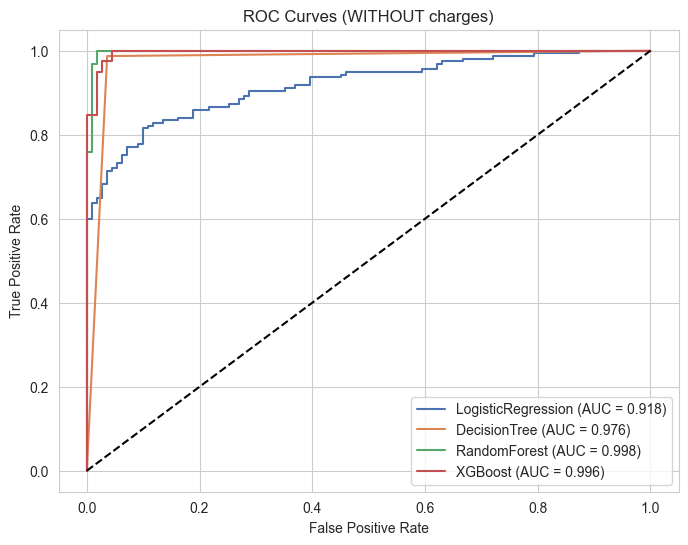

In [40]:
print("Training models WITHOUT charges feature (no leakage) ...")
models_without, results_without = train_and_evaluate(
    Xw_train, Xw_test, yw_train, yw_test, include_charges=False, do_grid=True
)

# ROC plot (without charges)
plot_roc(models_without, Xw_test, yw_test, title="ROC Curves (WITHOUT charges)")


Training models WITHOUT charges feature (safer) ...
Logistic best params: {'clf__C': 0.1}
--- Logistic Regression Evaluation ---
Accuracy: 0.8172
F1-score: 0.8492
Precision: 0.8214
Recall: 0.8790
ROC-AUC: 0.9175
Confusion Matrix:
[[ 81  30]
 [ 19 138]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       111
           1       0.82      0.88      0.85       157

    accuracy                           0.82       268
   macro avg       0.82      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

DecisionTree best params: {'clf__max_depth': 10, 'clf__min_samples_split': 2}
--- Decision Tree Evaluation ---
Accuracy: 0.9776
F1-score: 0.9810
Precision: 0.9748
Recall: 0.9873
ROC-AUC: 0.9756
Confusion Matrix:
[[107   4]
 [  2 155]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       111
           1       0.97     

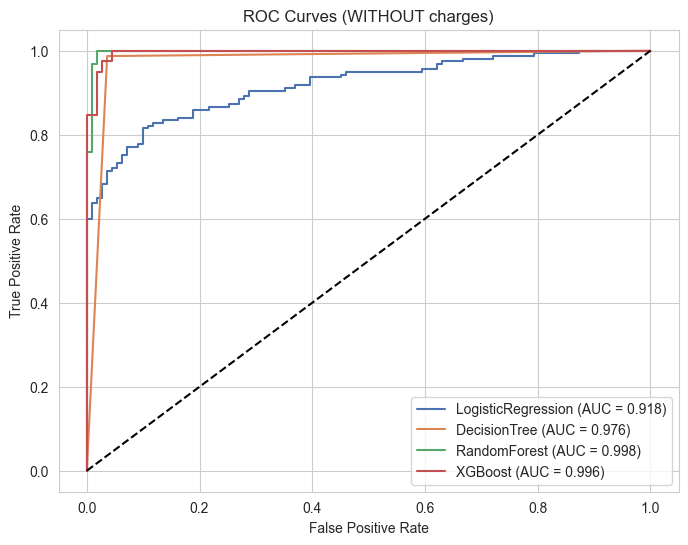

In [42]:
summary_with = pd.DataFrame(results_with).set_index('model')
summary_no = pd.DataFrame(results_no).set_index('model')

print("=== Results WITH charges ===")
display(summary_with.sort_values('f1', ascending=False))
print("\n=== Results WITHOUT charges ===")
display(summary_no.sort_values('f1', ascending=False))


best_model = models_no['XGBoost']
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/xgb_no_charges_joblib.pkl")
print("Saved model to models/xgb_no_charges_joblib.pkl")


=== Results WITH charges ===


,accuracy,f1,precision,recall,roc_auc
model,,,,,
Random Forest,0.977612,0.981132,0.968944,0.993631,0.993602
XGBoost,0.973881,0.978193,0.957317,1.000000,0.994606
Decision Tree,0.970149,0.974522,0.974522,0.974522,0.972313
Logistic Regression,0.820896,0.850000,0.834356,0.866242,0.913984



=== Results WITHOUT charges ===


,accuracy,f1,precision,recall,roc_auc
model,,,,,
Random Forest,0.981343,0.984326,0.969136,1.000000,0.997533
XGBoost,0.977612,0.981250,0.963190,1.000000,0.996328
Decision Tree,0.977612,0.981013,0.974843,0.987261,0.975613
Logistic Regression,0.817164,0.849231,0.821429,0.878981,0.917542


Saved model to models/xgb_no_charges_joblib.pkl


In [43]:
def predict_single(input_dict, model_path="models/xgb_no_charges_joblib.pkl"):
    """
    input_dict example:
    {
      'age': 45,
      'sex': 1,
      'bmi': 27.5,
      'children': 2,
      'smoker': 0,
      'region': 2,
      # 'charges' excluded for no-charges model
    }
    """
    model = joblib.load(model_path)
    df_input = pd.DataFrame([input_dict])
    
    # create derived features if missing
    if 'bmi_category' not in df_input.columns:
        df_input['bmi_category'] = pd.cut(df_input['bmi'], bins=[0,18.5,25,30,100], 
                                          labels=['underweight','normal','overweight','obese'])
    if 'age_bucket' not in df_input.columns:
        df_input['age_bucket'] = pd.cut(df_input['age'], bins=[0,25,40,60,120], 
                                        labels=['young','adult','midage','senior'])
    pred_proba = None
    pred = model.predict(df_input)[0]
    if hasattr(model, "predict_proba"):
        pred_proba = model.predict_proba(df_input)[:,1][0]
    return {'prediction': int(pred), 'probability': float(pred_proba) if pred_proba is not None else None}

# Quick sanity check
print("Sanity check predict:", predict_single({'age':30,'sex':1,'bmi':26,'children':0,'smoker':0,'region':0}))


Sanity check predict: {'prediction': 0, 'probability': 0.01885872893035412}


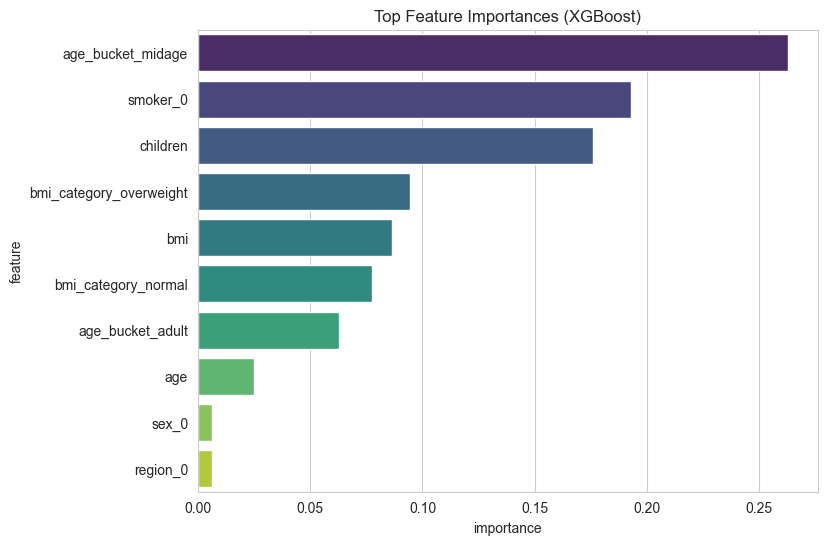

In [44]:
def plot_feature_importance(model, top_n=10):
    importances = model.named_steps['clf'].feature_importances_
    
    # get column names after preprocessing
    preprocessor = model.named_steps['pre']
    cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(
        preprocessor.transformers_[1][2]
    )
    num_features = preprocessor.transformers_[0][2]
    feature_names = list(num_features) + list(cat_features)
    
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi_df = fi_df.sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')
    plt.title("Top Feature Importances (XGBoost)")
    plt.show()

plot_feature_importance(best_model)